# **`Using Classification to Classify Awake/Drowsy`**

In [1]:
import os
import torch
import random
import numpy as np
import warnings
import cv2
import PIL.Image
import matplotlib.pyplot as plt
from insightface.app import FaceAnalysis
from torch import nn, optim
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Using `InsightFace` to crop images (that were gathered in awake_drowsy.ipynb as well as google images of faces) and will use those for EDA and modelling.

### Before that we'll feed live camera feed into IsightFace to demonstrate how its working.

### **`Live Camera Feed into InsightFace`**

In [14]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [15]:
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(160, 160))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/oscaramirmansour/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/oscaramirmansour/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/oscaramirmansour/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/oscaramirmansour/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/oscaramirmansour/.insightface/models/buffalo_l/w600k_r5

In [16]:
capture = cv2.VideoCapture(0)

In [ ]:
while True:
    ret, frame = capture.read()

    faces = app.get(frame)

    for face in faces:
        bbox = face.bbox.astype(int)
        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

    image_crop = frame[bbox[1]:bbox[3], bbox[0]:bbox[2], :]

    cv2.imshow('InsighFace Detecting Live Feed', image_crop)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

capture.release()
cv2.destroyAllWindows()

### **`Accessing Images and Cropping`**

In [2]:
data = '/Users/oscaramirmansour/AwakeDrowsy/data/Images'

output_folder = '/Users/oscaramirmansour/AwakeDrowsyObjDetec/data/Images_cropped'

All images in folder

In [19]:
images = [os.path.join(data, filename) for filename in os.listdir(data) if filename.endswith('.jpg')]

images

['/Users/oscaramirmansour/AwakeDrowsy/data/Images/drowsy.4cea0ede-8d6d-11ee-9868-784f434cfd22.jpg',
 '/Users/oscaramirmansour/AwakeDrowsy/data/Images/drowsy.ba625a34-8ed0-11ee-bc9a-784f434cfd22.jpg',
 '/Users/oscaramirmansour/AwakeDrowsy/data/Images/awake.75496d6c-8d6c-11ee-9868-784f434cfd22.jpg',
 '/Users/oscaramirmansour/AwakeDrowsy/data/Images/drowsy.e95c0552-8d6c-11ee-9868-784f434cfd22.jpg',
 '/Users/oscaramirmansour/AwakeDrowsy/data/Images/awake.6defa68a-8d6c-11ee-9868-784f434cfd22.jpg',
 '/Users/oscaramirmansour/AwakeDrowsy/data/Images/awake.d2aac3e8-8d6c-11ee-9868-784f434cfd22.jpg',
 '/Users/oscaramirmansour/AwakeDrowsy/data/Images/drowsy.359c4e72-8d6d-11ee-9868-784f434cfd22.jpg',
 '/Users/oscaramirmansour/AwakeDrowsy/data/Images/awake.cb4770ce-8d6c-11ee-9868-784f434cfd22.jpg',
 '/Users/oscaramirmansour/AwakeDrowsy/data/Images/awake.d16f16c8-8d6c-11ee-9868-784f434cfd22.jpg',
 '/Users/oscaramirmansour/AwakeDrowsy/data/Images/awake.953787e4-8d6c-11ee-9868-784f434cfd22.jpg',
 '/Use

Dividing above images into `awake` vs. `drowsy`

In [ ]:
awake_imgs = [img_path for img_path in images if os.path.basename(img_path).startswith('awake')]

drowsy_imgs = [img_path for img_path in images if os.path.basename(img_path).startswith('drowsy')]

print(f'Number of awake images: {len(awake_imgs)}')

print(f'Number of drowsy images: {len(drowsy_imgs)}')

Feeding images through InsightFace and outputing to output folder 'Images_cropped'

In [ ]:
for img_path in awake_imgs + drowsy_imgs:
    print(f'Image: {img_path}')
    
    try:
        img = cv2.imread(img_path)
        output_path = os.path.join(output_folder, os.path.basename(img_path))
        
        faces = app.get(img)

        if len(faces) > 0:
            bbox = faces[0]['bbox']
            # was getting error: `TypeError: slice indices must be integers or None or have an __index__ method`
            # so going to convert bounding box coordinates to int
            bbox = [int(coord) for coord in bbox]
            img_face = img[bbox[1]:bbox[3], bbox[0]:bbox[2], :]

            # saving cropped images to output folder: 'Images_cropped'
            output_path = os.path.join(output_folder, os.path.basename(img_path))
            cv2.imwrite(output_path, img_face)
        else:  
            print(f'No face detected in {img_path}')
    except:
        pass

Because we're training a classification model, we manually split the data into training, validation and test folders (which are found in the 'images_cropped' folder)

### **`Exploratory Data Analysis`**

### Image Paths

we can perform some EDA on the training data

In [3]:
train_data = '/Users/oscaramirmansour/AwakeDrowsy/data/Images_cropped/train'

test_data = '/Users/oscaramirmansour/AwakeDrowsy/data/Images_cropped/test'

valid_data = '/Users/oscaramirmansour/AwakeDrowsy/data/Images_cropped/validation'

### Sample Images

Let's have a look at the a random sample of the types of images we're working with

In [23]:
class_folders = [folder for folder in os.listdir(train_data) if os.path.isdir(os.path.join(train_data, folder))]

class_folders

['drowsy', 'awake']

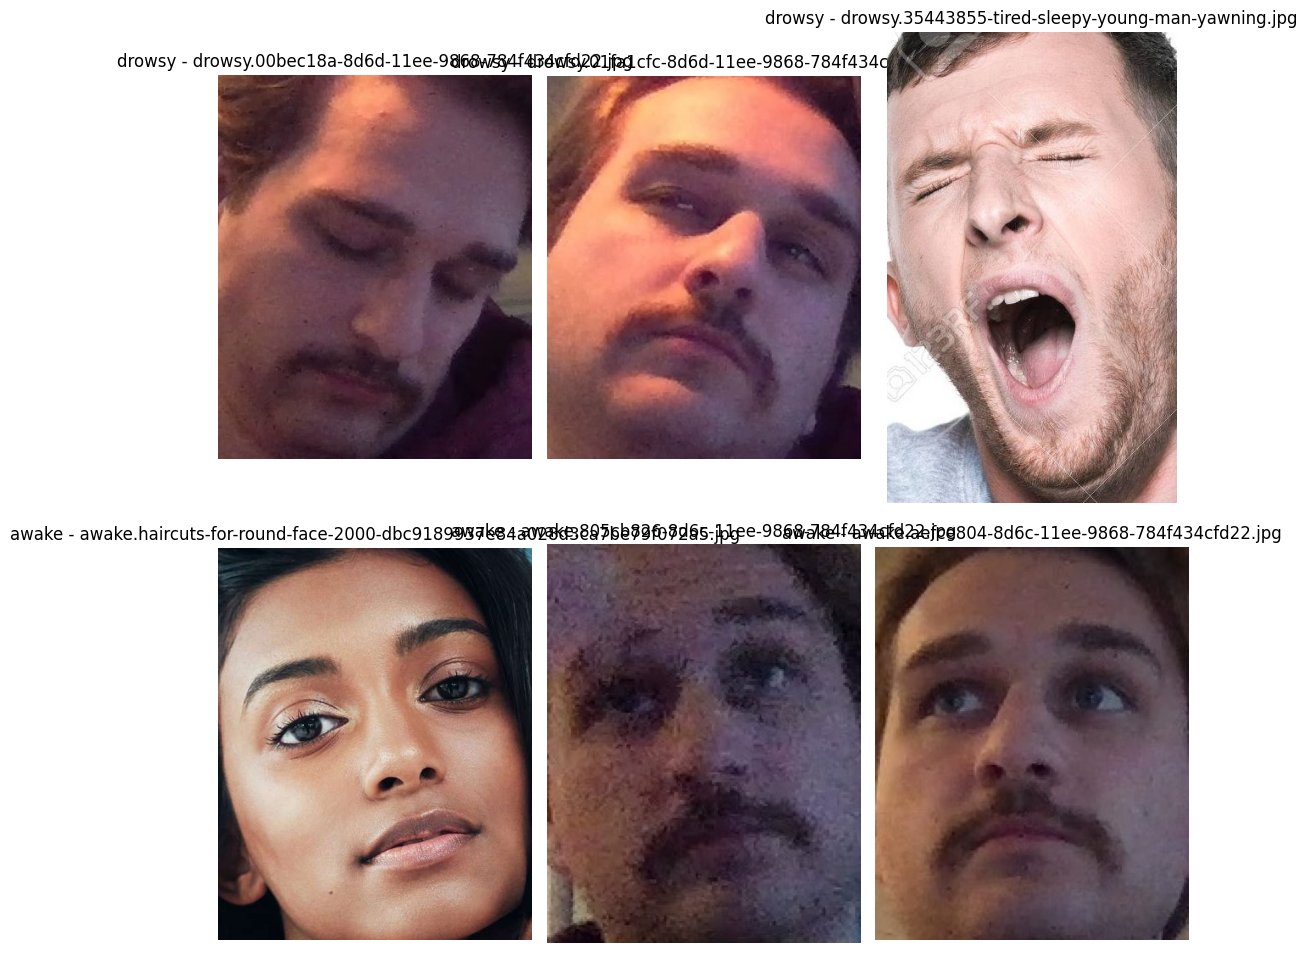

In [248]:
# Display sample images
fig, axes = plt.subplots(nrows=len(class_folders), ncols=3, figsize=(10, 5 * len(class_folders)))

for i, class_folder in enumerate(class_folders):
    class_path = os.path.join(train_data, class_folder)
    image_files = [file for file in os.listdir(class_path) if file.endswith('.jpg')]
    sample_images = random.sample(image_files, 3)

    for j, image_file in enumerate(sample_images):
        image_path = os.path.join(class_path, image_file)
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f'{class_folder} - {image_file}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

### Class Distribution

Despite having made my own dataset and am aware of the class distributions, lets have a look at it nonetheless.

We can see that they are almost identical - there are a tiny bit more awake images but i dont think there will be an issue of uneven classes.

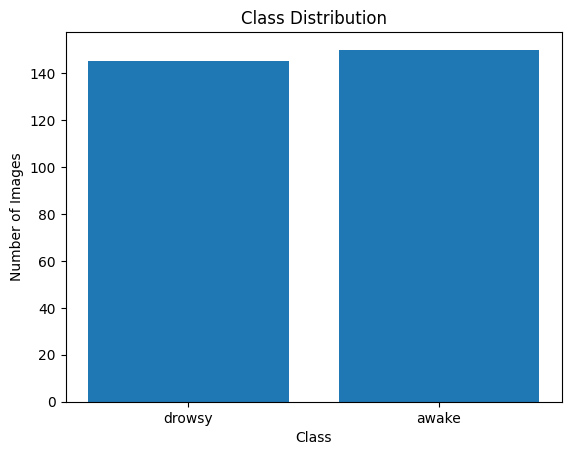

In [249]:
class_counts = {class_folder: len(os.listdir(os.path.join(train_data, class_folder))) for class_folder in class_folders}

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

### Let's have a look at the image size

Ideally we'd want uniform image sizes which will help with computational and memory efficiency. Having size consitent images also makes augmentation processes easier to perform.

We're only working with ~140 images in each class so not too worried about computational efficiency at this level however, at much greater number of images, this is an important factor to consider.

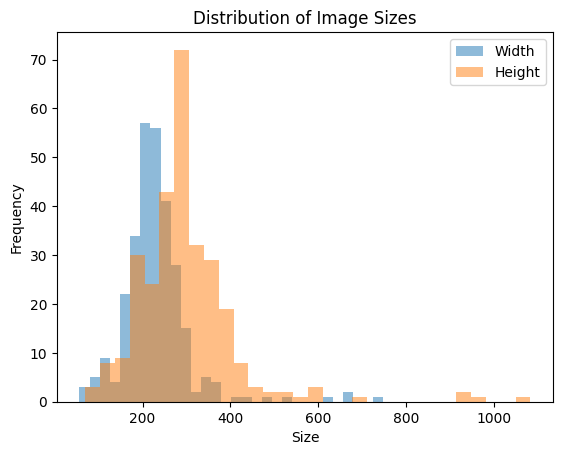

In [250]:
image_sizes = []

for class_folder in class_folders:
    class_path = os.path.join(train_data, class_folder)
    for image_file in os.listdir(class_path):
        if image_file.endswith('.jpg'):
            image_path = os.path.join(class_path, image_file)
            img = Image.open(image_path)
            image_sizes.append(img.size)

# Histogram of image sizes
sizes_x, sizes_y = zip(*image_sizes)
plt.hist(sizes_x, bins=30, alpha=0.5, label='Width')
plt.hist(sizes_y, bins=30, alpha=0.5, label='Height')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Image Sizes')
plt.show()


The difference in image sizes may be a problem so we'll need to ensure they'll all the same size.

### Examining Color Channels

Here we're trying to make sure that all our images are in RGB format so as to maintain consistency and thus maximise computational and memory efficiency.

In [ ]:
color_channels = []

for class_folder in class_folders:
    class_path = os.path.join(train_data, class_folder)
    for image_file in os.listdir(class_path):
        if image_file.endswith('.jpg'):
            image_path = os.path.join(class_path, image_file)
            img = Image.open(image_path)
            num_channels = img.getbands()
            color_channels.append(len(num_channels))

# histogram of color channels
plt.hist(color_channels, bins=3, alpha=0.5)
plt.xlabel('Num of Color Channels')
plt.ylabel('Freq')
plt.title('Dist of Color Channels')
plt.show()

# **`Classification Model`**

### Were going to use the images that were generated in awake_drowsy.ipynb (the YOLO model) as well as google images of random faces and use `InsightFace` to crop the images. InsightFace will automatically detect bounding boxes as opposed to `LabelImg` which requires users to manually draw bounding boxes and label images.

### We'll then augment/transform images using PyTorch.

### Let's do some transformations:

* First we're going to convert our images to PyTorch tensors which sclae the images pixel values from its normal range of [0,255] to [0,1]. This is a standard step when preparing images for convolutional neural networks.

* We're then going to normalise the tensor pixel values (subtracting mean and dividing by std dev for each color channel). This will then further scale the pixel value range from [-1, 1]. This will ulitmately help stabilize the learning during training.



In [26]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

In [4]:
transform_pipeline_train = transforms.Compose([

    transforms.Resize((320, 320)), # want to ensure consistent image sizes
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.0, hue=0.0),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.6),
    transforms.ToTensor(),
    #transforms.Normalize(mean=mean, std=std)

])

We only want to resize, convert to tensor and normalize test images - any other transformations/augmentations shouldn't be carried out as that isnt reflective of real life data.

In [5]:
transform_pipeline_test = transforms.Compose([

    transforms.Resize((320, 320)), # want to ensure consistent image sizes
    transforms.ToTensor(),
    #transforms.Normalize(mean=mean, std=std)

])

In [6]:
transform_pipeline_valid = transforms.Compose([

    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=mean, std=std)

])

### Bringing in our datasets

In [7]:
train_dataset = datasets.ImageFolder(root=train_data, transform=transform_pipeline_train)

test_dataset = datasets.ImageFolder(root=test_data, transform=transform_pipeline_test)

valid_dataset = datasets.ImageFolder(root=valid_data, transform=transform_pipeline_valid)

### Defining our data loaders

These will handle parameters like handling the batches of data we choose to train and if we decide whether to shuffle our data or not.

Here, we will shuffle and will set batch sizes to 16 given that the computer used does not have a dedicated GPU and in general isnt the greatest.

In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) 
# unlike with training data, we dont want to shuffle test data so as to not introduce any potential variability in results and also because real world data isnt shuffled and arrives in order.

valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

### Model selection

We're going to be using a pre-trained convolutional neural network for image handling - ResNet18

In [258]:
model = models.resnet18(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Given that we only have two classes: 'Awake' and 'Drowsy' we want to perform a binary classification and so we can modify the fully connected layers like so:

In [259]:
model.fc = nn.Sequential(
    # input layer with an the output size of 256 (model 3 will have 128)
    nn.Linear(model.fc.in_features, 128),
    
    # using a rectified linear activation function, which will replace all negative values with 0.
    nn.ReLU(),

    # regularization technique to prevent overfitting - here we're setting a fraction of 50% of input units to zero while training which ultimately steers the model in such a way that encourages the model to train on several pathways 
    # (Model 3 will have 0.3 droppeout instead of 0.5)
    nn.Dropout(0.3), 

    # final layer which corresponds to the output of the previous 2D output.
    nn.Linear(128, 2),

    nn.Softmax(dim=-1) # produce probabilities

)

### Defining an optimizer and loss function

In [260]:
lr = 0.00005
lr_ratio = 0.5
patience = 2
weight_decay = 1e-4 # 1e-6 for model 3 (best model yet)

#loss_function = nn.BCELoss(weight=None, size_average=None) # Binary cross-entropy loss, which is appropriate given that we're performing binary classification.
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# going to add a scheduler to dynamically adjust the learning rate throughout train to help convergence.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=patience, factor=lr_ratio)

### Setting training duration - Epochs.

In our object detection approach, our initial model (consisting of 30 images of both classes) trained for 500 epochs and post results our 'metrics/mAP-0.5' indicated that at around ~50 epochs a ~ mean average precision was achieved and so subesquent models trained over shorter periods - the next model trained for 100 epochs albeit now training on ~130 images for each class and ultimately we the final model trained on 30 epochs however with 141 images from each class.

Given that this approach is image classifcation we can start with 50 epochs and evaluate.

We should note that this is done locally and without a dedicated GPU so training/convergence will  inevitably take longer.

In [261]:
epochs = 25

### Checking for CUDA for parallel computing

As mentioned above, will be training on hardware thats lacks a GPU however, I do own a computer with an Nvidia RTX 3070 (8GB of VRAM) so it would be interesting to come back to this problem when I have access to it.

As such, will implement a check for CUDA availability, else use CPU:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

### Training for specified epochs

In [263]:
# evaluating training data
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_pred = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, pred = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_pred += np.sum((pred == labels).cpu().numpy())
    
    # evaluating validation data
    model.eval()
    running_loss_val = 0.0
    correct_pred_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in valid_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            
            outputs_val = model(inputs_val)
            loss_val = loss_function(outputs_val, labels_val)

            running_loss_val += loss_val.item()

            _, pred_val = torch.max(outputs_val.data, 1)
            total_samples_val += labels_val.size(0)
            correct_pred_val += (pred_val == labels_val).sum().item()

    scheduler.step(running_loss_val / len(valid_loader))  # adjusting learning rate at end of every epoch

    # Retrieving and appending current learning rate to above list
    curr_lr = optimizer.param_groups[0]['lr']

    print(f'Current Epoch {epoch + 1}/{epochs} | Training Loss: {running_loss / len(train_loader)} | Training Accuracy: {correct_pred / total_samples}')
    print(f'Current Epoch: {epoch + 1}/{epochs} | Validation Loss: {running_loss_val / len(valid_loader)} | Validation Accuracy: {correct_pred_val / total_samples_val}')
    print(f'Current Learning Rate: {curr_lr}\n')

Current Epoch 1/25 | Training Loss: 0.6372807590585006 | Training Accuracy: 0.6996587030716723
Current Epoch: 1/25 | Validation Loss: 0.646368682384491 | Validation Accuracy: 0.7222222222222222
Current Learning Rate: 5e-05

Current Epoch 2/25 | Training Loss: 0.4936348999801435 | Training Accuracy: 0.9078498293515358
Current Epoch: 2/25 | Validation Loss: 0.47333552440007526 | Validation Accuracy: 0.8888888888888888
Current Learning Rate: 5e-05

Current Epoch 3/25 | Training Loss: 0.40598262768042714 | Training Accuracy: 0.9488054607508533
Current Epoch: 3/25 | Validation Loss: 0.4032081961631775 | Validation Accuracy: 0.9166666666666666
Current Learning Rate: 5e-05

Current Epoch 4/25 | Training Loss: 0.3777696584400378 | Training Accuracy: 0.962457337883959
Current Epoch: 4/25 | Validation Loss: 0.4051162898540497 | Validation Accuracy: 0.8611111111111112
Current Learning Rate: 2.5e-05

Current Epoch 5/25 | Training Loss: 0.3660804801865628 | Training Accuracy: 0.9658703071672355
Cur

In [ ]:
for epoch in range(epochs):
    # training
    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, loss_function, device)

    # validation
    val_loss, val_accuracy = evaluate_epoch(model, valid_loader, loss_function, device)

    # scheduler to adjust learning rate
    adjust_lr(optimizer, scheduler, val_loss)

    # Get current learning rate while training
    curr_lr = current_learning_rate(optimizer)

    print(f'Current Epoch {epoch + 1}/{epochs} | Training Loss: {train_loss} | Training Accuracy: {train_accuracy}')
    print(f'Current Epoch: {epoch + 1}/{epochs} | Validation Loss: {val_loss} | Validation Accuracy: {val_accuracy}')
    print(f'Current Learning Rate: {curr_lr}\n')

# **`Testing the Model`**

In [264]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Let's see our model accuracy on both datasets:

In [265]:
def accuracy(loader, dataset):
    total = 0
    correct = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'{dataset} accuracy: {accuracy}')

# train data accuracy
accuracy(train_loader, "Training data")

# test data accuracy
accuracy(test_loader, 'Test data')


Training data accuracy: 0.9931740614334471
Test data accuracy: 0.9210526315789473


Model 1: Train acc - `1.0`, test acc - `94.74%`

Model 2: Training data accuracy: `0.9931740614334471` - Test data accuracy: `0.8947368421052632`

Model 3: Training data accuracy: `0.9931740614334471` - Test data accuracy: `0.9210526315789473`

Model 4: Training data accuracy: `0.9931740614334471` - Test data accuracy: `0.9210526315789473` (increased weight decay from 1e-6 to 1e-4, same result as Model 3)

We can finally save the trained model

In [266]:
torch.save(model.state_dict(), 'AwakeDrowsyResnet18_4.pth')

# **`Loading & Evaluating the Model 3`**

Specifying architecture of model 3 or 4

In [9]:
model_3 = models.resnet18(pretrained=True)

model_3.fc = nn.Sequential(
    nn.Linear(model_3.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2),
    nn.Softmax()
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
model_3.load_state_dict(torch.load('resnet_results/AwakeDrowsyResnet18_4.pth'))

<All keys matched successfully>

In [11]:
model_3.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
summary(model_3, (3, 320, 320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 160, 160]           9,408
       BatchNorm2d-2         [-1, 64, 160, 160]             128
              ReLU-3         [-1, 64, 160, 160]               0
         MaxPool2d-4           [-1, 64, 80, 80]               0
            Conv2d-5           [-1, 64, 80, 80]          36,864
       BatchNorm2d-6           [-1, 64, 80, 80]             128
              ReLU-7           [-1, 64, 80, 80]               0
            Conv2d-8           [-1, 64, 80, 80]          36,864
       BatchNorm2d-9           [-1, 64, 80, 80]             128
             ReLU-10           [-1, 64, 80, 80]               0
       BasicBlock-11           [-1, 64, 80, 80]               0
           Conv2d-12           [-1, 64, 80, 80]          36,864
      BatchNorm2d-13           [-1, 64, 80, 80]             128
             ReLU-14           [-1, 64,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_3.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**`Producing Metrics for Model 3`**

In [17]:
def create_metrics(loader, dataset):
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_3(inputs)
            _, predicted = torch.max(outputs.data, 1)

            true_labels.extend(labels.cpu().numpy() == 1) # Drowsy is our positive class
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1_score_value = f1_score(true_labels, predicted_labels)

    print(f'{dataset} Metrics:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1_score_value}')

# lets now calculate the metrics on the train, test and validation sets:
create_metrics(train_loader, 'Training Data')
create_metrics(test_loader, 'Test Data')
create_metrics(valid_loader, 'Validation Data')

Training Data Metrics:
Accuracy: 0.9897610921501706
Precision: 0.9862068965517241
Recall: 0.9930555555555556
F1 Score: 0.9896193771626298


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Test Data Metrics:
Accuracy: 0.9210526315789473
Precision: 0.8636363636363636
Recall: 1.0
F1 Score: 0.9268292682926829


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Validation Data Metrics:
Accuracy: 0.8611111111111112
Precision: 0.782608695652174
Recall: 1.0
F1 Score: 0.878048780487805


**`Let's do some live detection/classification`**

Using the same transformations as done on test data

In [14]:
live_detection_transform = transform_pipeline_test

In [15]:
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(320, 320))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/oscaramirmansour/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/oscaramirmansour/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/oscaramirmansour/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/oscaramirmansour/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/oscaramirmansour/.insightface/models/buffalo_l/w600k_r5

In [ ]:
capture = cv2.VideoCapture(0)

cv2.namedWindow('LIVE - InsightFace Detecting', cv2.WINDOW_NORMAL)

cv2.resizeWindow('LIVE - InsightFace Detecting', 800, 600)

while True:
    ret, frame = capture.read()

    faces = app.get(frame)

    for face in faces:
        bbox = face.bbox.astype(int)
        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

        image_crop = frame[bbox[1]:bbox[3], bbox[0]:bbox[2], :]

        pil_image = PIL.Image.fromarray(image_crop)

        input_tensor = live_detection_transform(pil_image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model_3(input_tensor)

            _, pred_class = torch.max(outputs, 1)

            cv2.putText(frame, f'Class: {pred_class.item()}', (bbox[0], bbox[3] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        
    cv2.imshow('LIVE - InsightFace Detecting', image_crop)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

capture.release()
cv2.destroyAllWindows()